In [2]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import time
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from transformers import BertTokenizerFast, AutoModel, AdamW
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from transformers import BertModel, BertConfig,BertTokenizerFast, BertForSequenceClassification
import mlflow
from dataloader import NlpTrainDataset,NlpTestDataset


/home/adil/anaconda3/envs/ma-gym/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [1]:
import numpy

In [2]:
mean([1,2,3])

NameError: name 'mean' is not defined

In [3]:
DATA_PATH = "data"
train_df = pd.read_json(DATA_PATH+"/train.json")
test_df = pd.read_json(DATA_PATH+"/test.json")
train_label = pd.read_csv(DATA_PATH+"/train_label.csv")

In [4]:
train, val, train_labels, val_labels = train_test_split(train_df,train_label['Category'],test_size=0.2,stratify=train_label['Category'])

In [10]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
a = NlpTrainDataset(val,val_labels,tokenizer)

In [4]:

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', return_dict=True,num_labels=28)
# for param in model.base_model.parameters():
#     param.requires_grad = False
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
train_encoding = tokenizer.batch_encode_plus(train['description'].to_list(),max_length = 170\
                                              ,padding=True,truncation=True)
val_encoding = tokenizer.batch_encode_plus(val['description'].to_list(),max_length = 170\
                                              ,padding=True,truncation=True)

/home/adil/anaconda3/envs/ma-gym/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification mode

In [5]:
class NlpTrainDataset(Dataset):
    def __init__(self,Id,labels,encodings):
        self.labels = labels.tolist()
        self.encodings = encodings
        self.Id  = Id.to_list()

    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['Id'] = self.Id[idx]
        return item

    def __len__(self):
        return len(self.labels)

    

<AxesSubplot:>

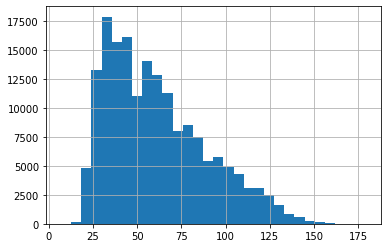

In [6]:
# seq_len = [len(i.split()) for i in train['description']]

# pd.Series(seq_len).hist(bins = 30)

In [7]:
train_dataset = NlpTrainDataset(train['Id'],train_labels,train_encoding)
val_dataset = NlpTrainDataset(val['Id'],val_labels,val_encoding)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
model = model.to(device)

In [11]:
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels.values)

# print("Class Weights:",class_weights)

In [12]:
# weights= torch.tensor(class_weights,dtype=torch.float)

# # # push to GPU
# weights = weights.to(device)        

# cross_entropy  = nn.CrossEntropyLoss(weight=weights)
cross_entropy  = nn.CrossEntropyLoss()
from transformers import get_linear_schedule_with_warmup

hyperparameters = {'epochs':epochs,'batch_size': batch_size, 'lr':lr, 'eps':eps,'optimizer': optimizer_name,
                   'loss': loss_name, 'alpha': alpha, 'gamma': gamma}
modules= {'model':model,'optimizer':optimizer,'scheduler':scheduler,'loss':loss}

# # number of training epochs
epochs = 10
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=16)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True,num_workers=16)
optimizer = AdamW(model.parameters(),lr = 5e-5,eps = 1e-8)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

alpha = 0.25
gamma = 2

In [13]:
def train():
   
  
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]
    total_labels = []

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
#         for key,value in batch.items():
#             batch[key] = batch[key].to(device)
            
        sent_id = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # clear previously calculated gradients 
        model.zero_grad()        

        # get model predictions for the current batch
        preds = model(sent_id, attention_mask=mask)
#         loss = cross_entropy(preds.logits, labels)
        ce_loss = nn.functional.cross_entropy(preds.logits,labels, reduction='none') # important to add reduction='none' to keep per-batch-item loss
        pt = torch.exp(-ce_loss)
        loss = (alpha * (1-pt)**gamma * ce_loss).mean()
        
        # compute the loss between actual and predicted values
        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        
        scheduler.step()
        
        
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.logits.detach().cpu().numpy()
        
        labels = labels.detach().cpu().numpy().tolist()
        
        # append the model predictions
        total_preds.append(preds)
        
        total_labels+= labels
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds, total_labels

In [14]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        sent_id = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, attention_mask=mask)
            
            # compute the validation loss between actual and predicted values
#             loss = cross_entropy(preds.logits,labels)
            ce_loss = nn.functional.cross_entropy(preds.logits,labels, reduction='none') # important to add reduction='none' to keep per-batch-item loss
            pt = torch.exp(-ce_loss)
            loss = (alpha * (1-pt)**gamma * ce_loss).mean()
            total_loss = total_loss + loss.item()

            preds = preds.logits.detach().cpu().numpy()
            
            labels = labels.detach().cpu().numpy().tolist()
            

            total_preds.append(preds)
            total_labels+=labels
            
            
            

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds, total_labels

In [16]:
def track(hyperparameters,metrics,model,epoch):
    if epoch == 0:
        for key,value in hyperparameters.items():
            mlflow.log_param(key, value)

    for key,value in metrics.items():
        log_metric(key=key, value=value, step=epoch)
        mlflow.pytorch.log_model(model, 'model_checkpoint')
        
        
        

/home/adil/anaconda3/envs/ma-gym/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, train_pred, train_lab = train()
    
    #evaluate model
    valid_loss, val_pred, val_lab = evaluate()
    
    
    res_train = np.argmax(train_pred,axis=1).tolist()
    res_val = np.argmax(val_pred,axis=1).tolist()
    
    f1_train = f1_score(train_lab, res_train,average='macro')
    f1_val = f1_score(val_lab, res_val,average='macro')
    
    mlflow.set_experiment(experiment_name=experiment_name)
    track(hyperparameters,metrics,model,epoch)
    
#     scheduler.step()
    torch.save(model.state_dict(), f'models/saved_weights_{epoch}_train_{train_loss:.3f}_valid_{valid_loss:.3f}.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    
    
    print(f'\nTraining Loss: {train_loss:.3f}, Training f1 : {f1_train}')
    print(f'Validation Loss: {valid_loss:.3f}, Validation f1 : {f1_val}')


 Epoch 1 / 10


RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 10.76 GiB total capacity; 2.62 GiB already allocated; 17.62 MiB free; 2.70 GiB reserved in total by PyTorch)

In [ ]:

# Training Loss: 0.172, Training f1 : 0.9270389230268575
# Validation Loss: 0.846, Validation f1 : 0.803059109809948

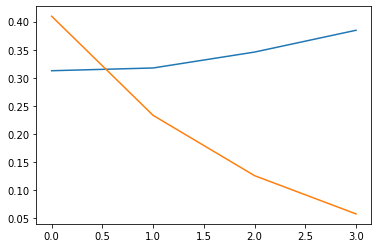

In [16]:
plt.plot(valid_losses)
plt.plot(train_losses)

In [14]:
#load weights of best model
path = 'models/saved_weights_3_train_0.058_valid_0.385.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [15]:
class NlpTrainDataset(Dataset):
    def __init__(self,encodings):
        self.encodings = encodings

    def __getitem__(self,idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return {'input_ids' : item['input_ids'].to(device), 'attention_mask' : item['attention_mask'].to(device)}

    def __len__(self):
        return len(self.encodings['input_ids'])

In [17]:
sent_id = val_encoding['input_ids']
mask = val_encoding['attention_mask']

In [18]:
testdata = NlpTrainDataset(val_encoding)
val_dataloader = DataLoader(testdata, batch_size=62)

In [19]:
total_preds = []
for batch in tqdm(val_dataloader):
    preds = model(batch['input_ids'], batch['attention_mask'])
    preds = preds.logits.detach().cpu().numpy()
    total_preds.append(preds)
    del preds
preds = np.argmax(np.concatenate(total_preds),axis=1)  

100%|██████████| 701/701 [02:24<00:00,  4.85it/s]


In [21]:
f1_score(val_labels.to_list(), preds,average='macro')

0.9246907680463821

In [22]:
# 0.9250927496719135 b5

In [16]:
test_encoding = tokenizer.batch_encode_plus(test_df['description'].to_list(),max_length = 170\
                                             ,padding=True,truncation=True)

In [17]:
testdata = NlpTrainDataset(test_encoding)
test_dataloader = DataLoader(testdata, batch_size=60)

In [18]:
total_preds = []
for batch in tqdm(test_dataloader):
    preds = model(batch['input_ids'], batch['attention_mask'])
    preds = preds.logits.detach().cpu().numpy()
    total_preds.append(preds)
    del preds

100%|██████████| 905/905 [03:04<00:00,  4.91it/s]


In [19]:
preds = np.argmax(np.concatenate(total_preds),axis=1)
submission = pd.DataFrame()
submission['Id'] = test_df['Id']
submission['Category'] = preds
submission.to_csv('bertpotential2.csv',index=False)